# Sky region

### Field star region selection.

We will begin without the Bailer-Jones priors. That will be later.

https://www.aanda.org/articles/aa/abs/2019/04/aa34337-18/aa34337-18.html

From here we will take a region on the sky with b=-35,l=160, we expect reddening increase around 400pc as per the paper above.

See Fig 5 (a).

Data input

In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import os
import torch
if('High_latitude_sample' in os.getcwd()):
    os.chdir('../')
from star_sample import StarSample, Isochrones





job4 = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source AS g, gaiadr3.astrophysical_parameters AS p, gaiaedr3_distance as d \
WHERE g.source_id = p.source_id \
AND g.source_id=d.source_id \
AND CONTAINS(POINT(g.l,g.b),CIRCLE(160.0,-35.0,2))=1;", dump_to_file=False)


r = job4.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


We need some prior on the distance but for now we wil just use the parallax.

# Parallax error

As per Bailer Jones, prior needed for about 20 percent error on parallax, which amounts to 40% of the stars along the line of sight.

In [2]:
r['error_over_parallax']=1/r['parallax_over_error']
(r['error_over_parallax']<0.2).sum()/len(r)

0.46991049101404564

In [3]:
#r=r[r['error_over_parallax']<0.4]
#r=r[r['error_over_parallax']>-0.4]

In [4]:
r['pdist']=1/r['parallax']


In [5]:
r

solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,solution_id_2,source_id_2,classprob_dsc_combmod_quasar_2,classprob_dsc_combmod_galaxy_2,classprob_dsc_combmod_star_2,classprob_dsc_combmod_whitedwarf,classprob_dsc_combmod_binarystar,classprob_dsc_specmod_quasar,classprob_dsc_specmod_galaxy,classprob_dsc_specmod_star,classprob_dsc_specmod_whitedwarf,classprob_dsc_specmod_binarystar,classprob_dsc_allosmod_quasar,classprob_dsc_allosmod_galaxy,classprob_dsc_allosmod_star,teff_gspphot_2,teff_gspphot_lower_2,teff_gspphot_upper_2,logg_gspphot_2,logg_gspphot_lower_2,logg_gspphot_upper_2,mh_gspphot_2,mh_gspphot_lower_2,mh_gspphot_upper_2,distance_gspphot_2,distance_gspphot_lower_2,distance_gspphot_upper_2,azero_gspphot_2,azero_gspphot_lower_2,azero_gspphot_upper_2,ag_gspphot_2,ag_gspphot_lower_2,ag_gspphot_upper_2,abp_gspphot,abp_gspphot_lower,abp_gspphot_upper,arp_gspphot,arp_gspphot_lower,arp_gspphot_upper,ebpminrp_gspphot_2,ebpminrp_gspphot_lower_2,ebpminrp_gspphot_upper_2,mg_gspphot,mg_gspphot_lower,mg_gspphot_upper,radius_gspphot,radius_gspphot_lower,radius_gspphot_upper,logposterior_gspphot,mcmcaccept_gspphot,libname_gspphot_2,teff_gspspec,teff_gspspec_lower,teff_gspspec_upper,logg_gspspec,logg_gspspec_lower,logg_gspspec_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec

# Distance Distribution

Seems to be plenty of stars in front and behind of the expected cloud at 400pc. Distance in plot is in kpc.

Text(0, 0.5, 'count')

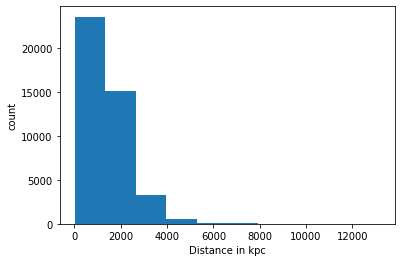

In [6]:
plt.hist(r['r_med_geo'])
plt.xlabel('Distance in kpc')
plt.ylabel('count')

# Plot of Distance vs Ag

Text(0.5, 1.0, 'Extinction vs Distance')

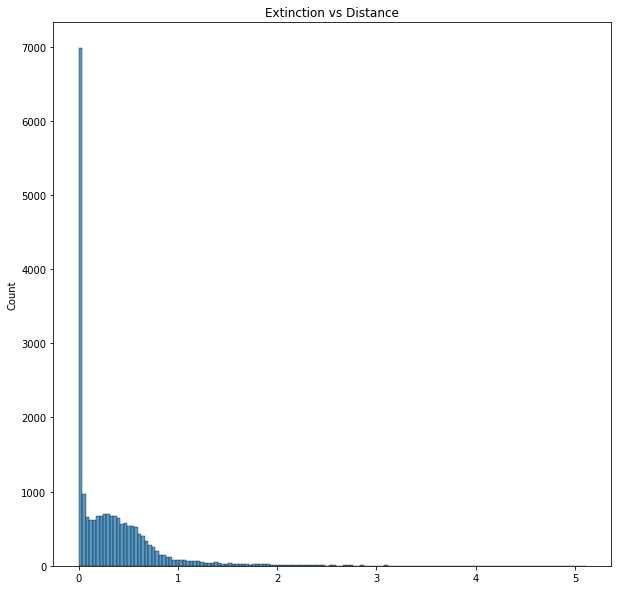

In [7]:
plt.figure(figsize=(10,10))
sn.histplot(r['ag_gspphot'])
#plt.xlim(0,2)
plt.title('Extinction vs Distance')

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

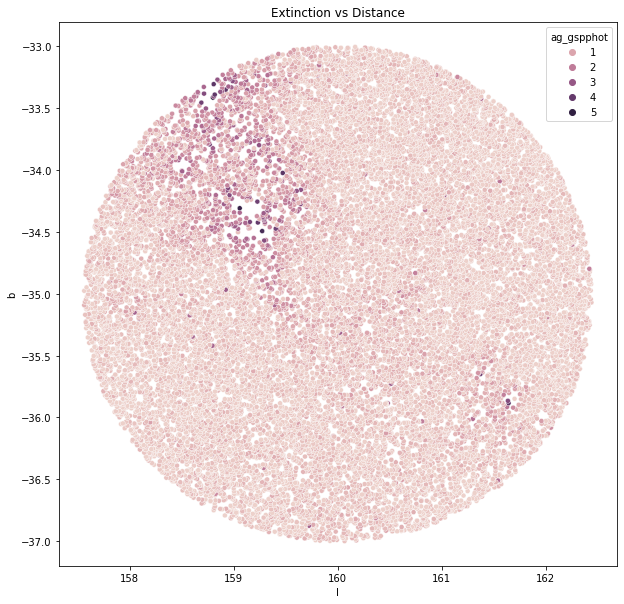

In [8]:
plt.figure(figsize=(10,10))
sn.scatterplot(r['l'],r['b'],hue=r['ag_gspphot'],color='r',s=25)
#plt.xlim(0,2)
plt.title('Extinction vs Distance')

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

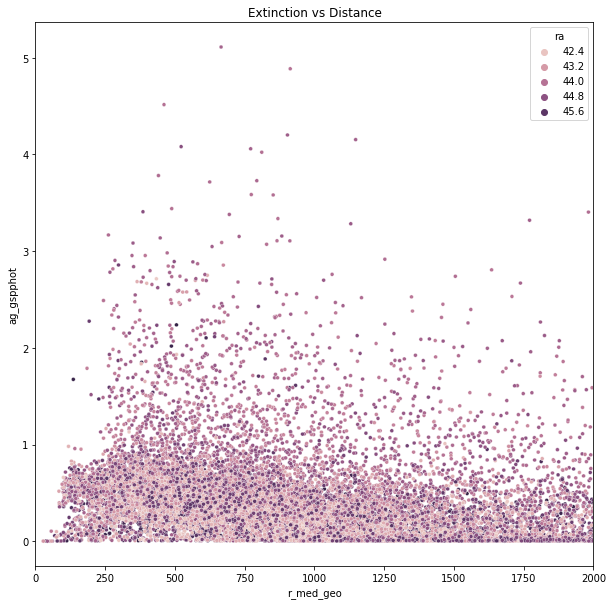

In [9]:
plt.figure(figsize=(10,10))
sn.scatterplot(r['r_med_geo'],r['ag_gspphot'],hue=r['ra'],color='r',s=15)
plt.xlim(0,2000)
plt.title('Extinction vs Distance')

In [10]:
high_lat=r.to_pandas()
high_lat=high_lat.dropna(axis=0,subset='mh_gspphot').reset_index(drop=True)

# Star_sample creation

In [11]:

import gdr3apcal


# some pandas data frame with your data from GACS using GACS column names
# Instantiate calibration object
calib = gdr3apcal.GaiaDR3_GSPPhot_cal()
# Apply calibrations to [M/H] and/or Teff, returning a numpy array of calibrated values.
metal_calib = calib.calibrateMetallicity(high_lat)



high_lat=high_lat[['ra','dec','parallax','phot_g_mean_mag','phot_g_mean_flux','phot_rp_mean_flux','phot_bp_mean_flux',
                        'phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','ra_error','dec_error',
                        'parallax_error','phot_g_mean_flux_error','phot_bp_mean_flux_error',
                        'phot_rp_mean_flux_error','mh_gspphot','logg_gspphot','ag_gspphot','r_med_geo']].reset_index(drop=True)

features=[['ra','dec','parallax','phot_g_mean_mag','bp_rp','rgeo']]
errors=[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error']]

#high_lat=high_lat.dropna(subset='parallax').reset_index(drop=True)

Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].


In [12]:
high_lat=StarSample(high_lat,features,errors)


# Isochrones

In [13]:
filters = ["Gaia_G_EDR3", "Gaia_BP_EDR3", 'Gaia_RP_EDR3']
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = np.linspace(9.0,10.0,10)
fehgrid = np.linspace(-2,0.5,110)
isocs=Isochrones(filters,logagegrid,massgrid,fehgrid,override=2.02)

# Pickle save

In [14]:
os.getcwd()

'/Users/mattocallaghan/VaeStar'

In [15]:
import pickle
os.chdir("Data")

output=open('isochrones_high_lat.pkl','wb') #convert to a dataframe
pickle.dump(isocs,output) #save to file



In [18]:
output=open('high_lat_values.pkl','wb') #convert to a dataframe
pickle.dump(high_lat,output)#save to file
#os.chdir('..')

In [ ]:
high_lat.to_tensor()

tensor([[[4.6172e+01, 1.8588e+01,        nan,  ..., 9.2364e-02,
          1.0123e-01, 1.3703e-01]],

        [[4.6321e+01, 1.8290e+01, 9.3225e-01,  ..., 4.7984e-03,
          3.1574e-03, 5.7441e-03]],

        [[4.6318e+01, 1.8306e+01,        nan,  ..., 5.4686e-02,
          2.1807e-02, 5.8873e-02]],

        ...,

        [[4.4202e+01, 2.0658e+01, 5.4428e+00,  ..., 2.2595e-01,
          3.7340e-02, 2.2902e-01]],

        [[4.4144e+01, 2.0660e+01, 1.0280e+00,  ..., 6.8237e-03,
          3.0154e-03, 7.4603e-03]],

        [[4.4082e+01, 2.0653e+01,        nan,  ...,        nan,
          1.7033e-01,        nan]]], dtype=torch.float64)

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

,ra,dec,parallax,phot_g_mean_mag,phot_g_mean_flux,phot_rp_mean_flux,phot_bp_mean_flux,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,...,parallax_error,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,mh_gspphot,logg_gspphot,phot_g_mean_mag_error,bp_error,rp_error,bp_rp_error
0,44.281352,18.681245,0.743010,17.799953,1428.779116,1271.527708,557.732506,18.472477,16.987082,1.485395,...,0.124104,1.812249,11.057135,8.604890,-0.6505,4.7668,0.003080,0.021854,0.007860,0.023224
1,44.269818,18.654219,0.548729,16.749699,3758.959618,2980.249978,1655.067637,17.291502,16.062263,1.229239,...,0.070739,2.924474,18.865709,12.938982,-0.9396,4.7176,0.002882,0.012940,0.005478,0.014052
2,44.262053,18.652386,0.662536,15.548326,11366.228981,8563.711462,5453.401133,15.996874,14.916241,1.080633,...,0.042139,6.680903,14.635385,16.373699,-0.3245,4.3916,0.002828,0.004772,0.003478,0.005905
3,44.260644,18.650630,NaN,20.994844,75.337077,NaN,NaN,NaN,NaN,NaN,...,NaN,1.571888,NaN,NaN,NaN,NaN,0.022821,NaN,NaN,NaN
4,44.264347,18.649301,0.766578,14.243190,37815.584163,27384.137345,18740.359287,14.656597,13.654148,1.002449,...,0.020719,9.631531,29.684752,32.478729,-0.4244,4.0701,0.002769,0.004152,0.003073,0.005166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27187,46.249300,16.691827,1.399086,14.735081,24038.891456,17538.299286,12098.258385,15.131735,14.137927,0.993808,...,0.034192,9.724405,28.812962,36.886971,-0.8913,4.5522,0.002790,0.004579,0.003606,0.005828
27188,42.309880,16.675617,NaN,21.635550,41.756744,466.658190,158.660810,19.837368,18.075397,1.761971,...,NaN,1.320303,11.284405,22.821953,NaN,NaN,0.034440,0.077313,0.053171,0.093832
27189,46.257789,20.670736,1.105224,18.481249,762.864174,843.892023,175.138875,19.730085,17.432178,2.297907,...,0.220675,1.591388,11.129131,9.600273,0.0042,4.4945,0.003567,0.069096,0.012663,0.070247
27190,42.292541,16.676993,1.524901,18.447952,786.621255,943.885421,165.215341,19.793417,17.310596,2.482821,...,0.184836,1.698052,7.480907,20.985384,-0.8154,4.6220,0.003617,0.049307,0.024300,0.054970


# HR diagram

(array([7., 5., 5., 6., 1., 5., 2., 1., 5., 4.]),
 array([0.1659    , 0.1668    , 0.16770001, 0.16860001, 0.16950001,
        0.1704    , 0.1713    , 0.1722    , 0.1731    , 0.174     ,
        0.1749    ], dtype=float32),
 <BarContainer object of 10 artists>)

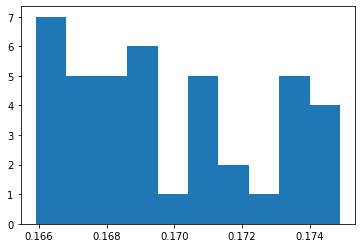

In [ ]:
high_lat.data=high_lat.data[high_lat.data['mh_gspphot']>0.165].reset_index(drop=True)
high_lat.data=high_lat.data[high_lat.data['mh_gspphot']<0.175].reset_index(drop=True)
plt.hist(high_lat.data['mh_gspphot'])

In [ ]:
high_lat.data.head(5)

,dist,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,error_over_parallax,pdist,phot_g_mean_mag_error,bp_error,rp_error,bp_rp_error,G
0,0.326618,1636148068921376768,Gaia DR3 84022930543557376,84022930543557376,154422376,2016.0,44.394184,0.049547,18.978551,0.041995,...,0.2664,0.2849,PHOENIX,0.028093,0.525560,0.002869,0.005596,0.003600,0.006654,7.441757
1,0.365930,1636148068921376768,Gaia DR3 35966678907628288,35966678907628288,762256713,2016.0,44.644299,0.028807,18.769796,0.023141,...,0.1723,0.2009,MARCS,0.018865,0.594314,0.002783,0.004678,0.003344,0.005750,6.048600
2,0.387801,1636148068921376768,Gaia DR3 83944212383021184,83944212383021184,863636240,2016.0,44.049249,0.025355,18.998950,0.020548,...,0.3797,0.3907,MARCS,0.008967,0.322262,0.002784,0.005249,0.003017,0.006055,7.406362
3,0.443895,1636148068921376768,Gaia DR3 35985439324772224,35985439324772224,92201530,2016.0,44.679718,0.046311,18.891783,0.039183,...,0.4626,0.4737,PHOENIX,0.021908,0.401964,0.002849,0.010331,0.003205,0.010817,8.193524
4,0.614748,1636148068921376768,Gaia DR3 84049971657597440,84049971657597440,257165352,2016.0,44.334234,0.124496,19.285119,0.122864,...,0.7463,0.7826,MARCS,0.088049,0.523684,0.004998,0.026946,0.005339,0.027470,8.678772


# CM Diagram

These metalicities in the Gaia catalogue have systematic uncertainties so have to be changed. The hue is these provided metalicities.

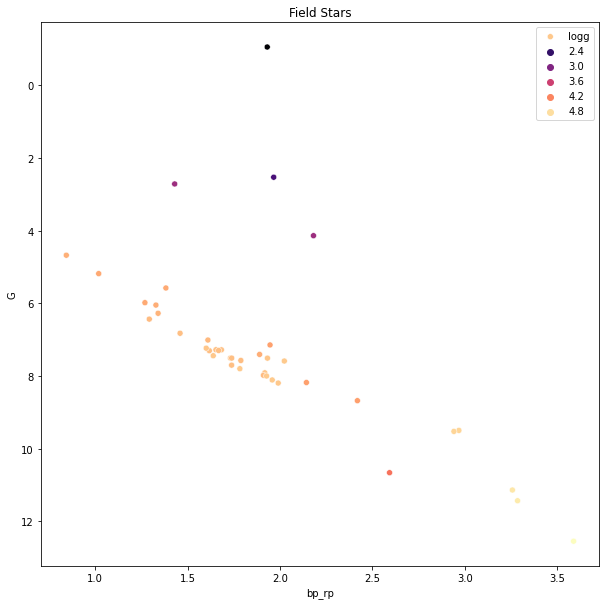

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)

scatter=high_lat.data
sn.scatterplot(x=scatter['bp_rp'],y=scatter['G'],hue=scatter['logg_gspphot'],ax=axes,label='logg',color='g',palette=sn.color_palette("magma", as_cmap=True))

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Field Stars")
plt.show()

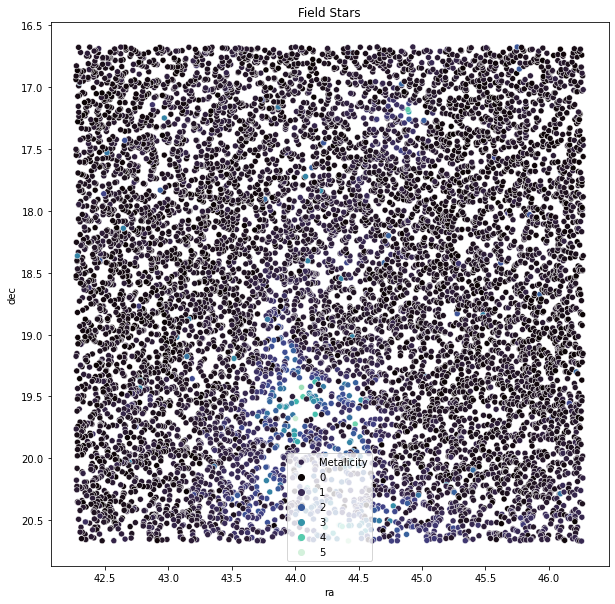

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=r[r['pdist']<1]
scatter=scatter[scatter['pdist']>0.0]
sn.scatterplot(x=scatter['ra'],y=scatter['dec'],hue=scatter['ag_gspphot'],ax=axes,label='Metalicity',color='g',palette=sn.color_palette("mako", as_cmap=True))

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Field Stars")
plt.show()

# Here on in we assume we are pointing at the cloud region.

In general, we probably cant always use extinction to identify clouds. But for now, we are using the extinction to make sure we are roughly pointed at a cloud. We will begin by looking at the region in the distance range less than 1kpc.

KeyError: 'mean_absolute_mag_g_band'

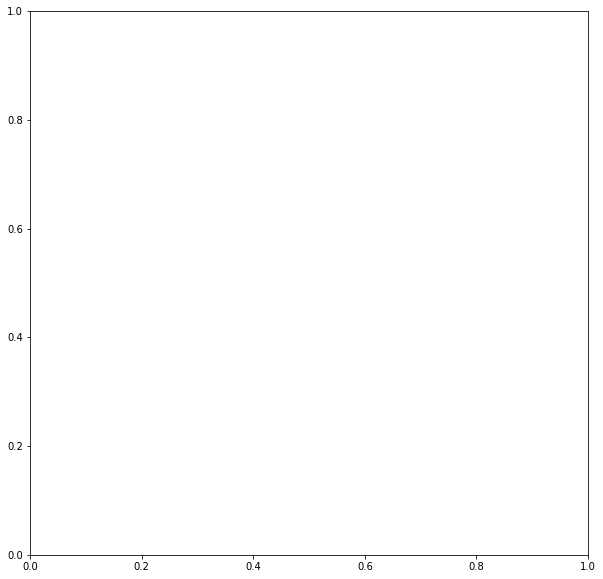

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=r[r['pdist']<1]
scatter2=scatter
#scatter=scatter[scatter['pdist']>0.1]
scatter=scatter[scatter['ra']>43]
scatter=scatter[scatter['ra']<45.5]
scatter=scatter[scatter['dec']>19.0]
scatter=scatter[scatter['rv_template_fe_h']>-0.1]
scatter=scatter[scatter['rv_template_fe_h']<0.1]

sn.scatterplot(x=scatter2['bp_rp'],y=scatter2['mean_absolute_mag_g_band'],ax=axes,s=10,color='g',label='no metalicity')
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rv_template_fe_h'],ax=axes,s=10,palette=sn.color_palette("magma", as_cmap=True))
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,color='r')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
#plt.legend()
axes.set_title("Field Stars")
plt.show()

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Extinction vs Distance')

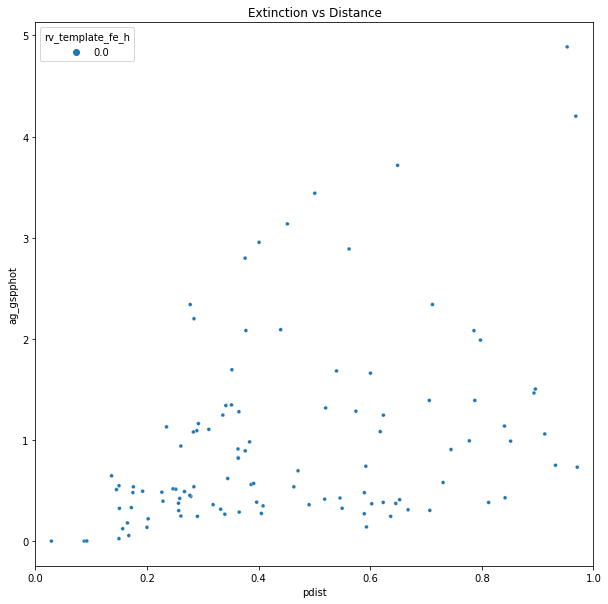

In [ ]:
plt.figure(figsize=(10,10))
sn.scatterplot(scatter['pdist'],scatter['ag_gspphot'],hue=scatter['rv_template_fe_h'],color='r',s=15)
plt.xlim(0,1)
plt.title('Extinction vs Distance')

In [ ]:
type(r)

astropy.table.table.Table

In [ ]:
r.sort('pdist')

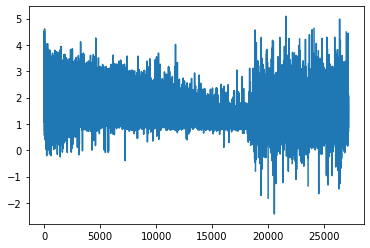

In [ ]:
plt.plot(r['bp_rp'])